In [1]:
import pandas as pd
import numpy as np
import timm
import torchvision.transforms as T
import torch
import itertools
from torch.optim import SGD
import os

from wildlife_tools.train import ArcFaceLoss, BasicTrainer, set_seed
from wildlife_tools.features import DeepFeatures
from wildlife_tools.data import ImageDataset, SafeImageDataset
from sklearn.metrics.pairwise import cosine_distances




/home/users/dash/guppies/embeddings/wildlife-tools/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


# Load metadata
PT_CSV = '/home/users/dash/guppies/embeddings/wildlife-tools/exploring/csvs/top_30000_individuals_database.csv'
PT_images = '/gws/nopw/j04/iecdt/dash/cropped_images/id/w_random_masks'
PT_storage = '/gws/nopw/j04/iecdt/dash/embeddings/models'
df = pd.read_csv(PT_CSV)
# df['path'] = df['path'].str.replace('.JPG', '.png', case=False)
# df.to_csv(PT_CSV, index=False)
df.head()

,identity,path,date
0,1750,1206/Lower LaLaja/28a/DCIM/100NCD90/DSC_0012.png,2012-06-28
1,1750,1207/Lower Lalaja/29b/DCIM/100NCD60/DSC_4746.png,2012-07-29
2,1750,1208/Lower Lalaja/27B/100NCD90/DSC_0153.png,2012-08-27
3,5003,1208/Upper Lalaja/2B/100NCD90/DSC_0157.png,2012-09-02
4,5003,1209/Upper Lalaja/3B/100NCD90/DSC_0099.png,2012-10-03


In [ ]:
import pynvml

pynvml.nvmlInit()
device_count = torch.cuda.device_count()
max_free_mem = 0
best_device = 0

for i in range(device_count):
    handle = pynvml.nvmlDeviceGetHandleByIndex(i)
    mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    if mem_info.free > max_free_mem:
        max_free_mem = mem_info.free
        best_device = i

device = torch.device(f'cuda:{best_device}')
print(f'using gpu {device} out of {torch.cuda.device_count()}')

using gpu cuda:2 out of 4


# load model

In [5]:

# Define image transformations
transform = T.Compose([
    T.Resize((224, 224)),  # Resize to match MegaDescriptor-L-384 input
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create ImageDataset
database_dataset = SafeImageDataset(df, root=PT_images, transform=transform, log_file='unreadable_images.txt')

In [5]:
# Load the MegaDescriptor model
# backbone = timm.create_model('hf-hub:BVRA/MegaDescriptor-L-384', pretrained=True, num_classes=0)
backbone = timm.create_model('hf-hub:BVRA/MegaDescriptor-T-224', pretrained=True, num_classes=0)


In [ ]:
save_path = '/gws/nopw/j04/iecdt/dash/embeddings/models/MGD/MGD_30000ids_arcface/model_epoch_10.pt/checkpoint.pth'
checkpoint = torch.load(save_path, map_location=device, weights_only=False)
print(checkpoint.keys())

dict_keys(['model', 'objective', 'optimizer', 'epoch', 'rng_states'])


In [7]:
backbone.load_state_dict(checkpoint['model'])

<All keys matched successfully>

# get embeddings

In [8]:

extractor = DeepFeatures(backbone, device=device)

# Extract features
features = extractor(database_dataset)


100%|█████████████████████████████████████████████████████████| 1174/1174 [1:32:58<00:00,  4.75s/it]


In [9]:
assert len(features) == len(database_dataset)
assert tuple(features.features.shape) == (len(database_dataset), 768)

In [10]:
# Convert embeddings to NumPy array
embeddings = features.features
if isinstance(embeddings, torch.Tensor):
    embeddings = embeddings.detach().cpu().numpy()

# Extract labels
labels = features.labels_string  # Assuming labels are stored here

# save embeddings

In [3]:
# Save embeddings and labels to an NPZ file
import os
import numpy as np

# Define save path
save_dir = '/gws/nopw/j04/iecdt/dash/embeddings/models/MGD/MGD_30000ids_arcface/model_epoch_10.pt/'
save_file = os.path.join(save_dir, 'top_30000_ids_database_embeddings.npz')


In [ ]:

# Ensure directory exists
os.makedirs(save_dir, exist_ok=True)

# Save both embeddings and labels in a single NPZ file
np.savez(save_file, 
         embeddings=embeddings,
         labels=labels)

print(f"Embeddings and labels saved to {save_file}")

# load embeddings

In [6]:
# To load the data later:
loaded_data = np.load('/gws/nopw/j04/iecdt/dash/embeddings/models/MGD/MGD_30000ids_arcface/model_epoch_10.pt/top_30000_ids_database_embeddings.npz', allow_pickle=True)
embeddings = loaded_data['embeddings']
labels = loaded_data['labels']

In [8]:
print(labels[:10])  # Print first 10 labels for verification
print(len(set(labels))) #number of individuals
print(embeddings.shape)

['1750' '1750' '1750' '5003' '5003' '5700' '5700' '5717' '5717' '5717']
29997
(150234, 768)


# average embeddings (one per individual)

In [12]:

# Combine extracted features with metadata
embeddings_df = pd.DataFrame(embeddings)
embeddings_df['identity'] = labels

# Group by identity and calculate the mean embedding for each individual
mean_embeddings = embeddings_df.groupby('identity').mean()

# `mean_embeddings` is now a DataFrame where each row index is an 'identity'
# and the columns are the dimensions of your embedding vector.

In [13]:
mean_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
identity,,,,,,,,,,,,,,,,,,,,,
100003,0.296021,0.141616,1.467761,-1.066410,0.204541,0.817946,-0.246641,-0.480063,2.774393,-0.513862,...,0.098022,-0.950645,0.492656,1.373581,0.174599,-1.683141,1.521226,-0.384945,-0.357430,0.561185
100007,0.390116,2.533535,-0.635320,0.007516,-1.151046,0.140921,0.841570,-0.224674,0.999989,-1.633500,...,-0.407934,-0.854291,0.245579,0.110347,-0.385689,0.461935,-0.492979,1.064923,0.258514,-0.172038
100014,-1.072955,0.245526,0.613057,0.181884,-0.105749,0.166675,1.377275,-0.331030,-0.046137,-1.186576,...,-0.240593,0.400168,-0.570077,-0.559362,0.172291,-0.150697,0.046327,-0.361426,1.226707,-0.053895
100017,0.897943,1.072091,1.455003,-1.656120,0.178799,0.034995,0.983140,-0.661539,0.935541,-0.626345,...,1.460189,-1.619959,1.074836,-0.244464,-0.493183,-0.081547,-0.189393,0.834409,0.500026,-0.460415
100018,1.065247,0.165416,0.610445,-0.445862,0.721472,0.253129,-0.180649,0.326869,0.271846,-0.192885,...,0.635814,-0.908698,1.150866,-0.595108,-1.005371,-0.215622,-0.278767,-0.642892,1.098364,-1.403972


# Pairwise similarity

In [14]:
#cosine_distances to compute the pairwise distance matrix.
#    This returns a NumPy array.
distance_array = cosine_distances(mean_embeddings)

# 2. Convert the NumPy array back to a labeled pandas DataFrame.
#    The index and columns of the original `mean_embeddings` DataFrame are the fish IDs.
distance_matrix = pd.DataFrame(
    distance_array,
    index=mean_embeddings.index,
    columns=mean_embeddings.index
)

# Now, `distance_matrix` is a DataFrame where both rows and columns are fish IDs,
# and each cell (i, j) contains the cosine distance between them.
print("--- Pairwise Distance Matrix ---")
print(distance_matrix.head())

--- Pairwise Distance Matrix ---
identity    100003    100007    100014    100017    100018    100021  \
identity                                                               
100003    0.000000  0.928101  0.822710  0.867961  0.841698  1.057579   
100007    0.928101  0.000000  0.754936  0.913731  0.895735  0.980785   
100014    0.822710  0.754936  0.000000  0.807829  0.757871  0.844698   
100017    0.867961  0.913731  0.807829  0.000000  0.424936  0.852200   
100018    0.841698  0.895735  0.757871  0.424936  0.000000  0.742306   

identity    100023    100025    100026    100027  ...     99982     99983  \
identity                                          ...                       
100003    1.007488  0.897901  0.954313  0.722874  ...  0.986565  0.935999   
100007    0.798769  0.871198  0.865788  0.939114  ...  0.759979  0.909102   
100014    0.685214  0.683873  0.631263  0.703392  ...  0.942012  0.906543   
100017    0.870077  0.750171  0.732806  0.696535  ...  0.937480  1.032974   


In [ ]:
from scipy import sparse
import numpy as np
sparse_save_path = f"{save_dir}30000_ids_db_pairwise_distance_sparse.npz"


In [ ]:

# Create a more efficient representation of the distance matrix (symmetric)
#  only need to store the upper triangular part, excluding the diagonal

# Get the upper triangular part (excluding diagonal)
i_upper = np.triu_indices_from(distance_matrix.values, k=1)
distances_upper = distance_matrix.values[i_upper]

# Create sparse matrix in COO format
sparse_distance_matrix = sparse.coo_matrix(
    (distances_upper, (i_upper[0], i_upper[1])), 
    shape=distance_matrix.shape
)

# Save in efficient npz format
sparse.save_npz(sparse_save_path, sparse_distance_matrix)
print(f"Sparse distance matrix saved to {sparse_save_path}")


# load sparse distance

In [9]:
sparse_distance_matrix = sparse.load_npz(sparse_save_path)

In [13]:
# Convert the sparse matrix to a DataFrame with columns id_1, id_2, distance
# First, get the indices and data from the sparse matrix
row_indices, col_indices = sparse_distance_matrix.nonzero()
distances = sparse_distance_matrix.data

# Create a DataFrame, indexs from the mean_embeddings index
sparse_df = pd.DataFrame({
    'id_1': mean_embeddings.index[row_indices],
    'id_2': mean_embeddings.index[col_indices],
    'distance': distances
})

# Verify the data
print(f"Sparse DataFrame shape: {sparse_df.shape}")
print(sparse_df.head())


Sparse DataFrame shape: (449895006, 3)
     id_1    id_2  distance
0  100003  100007  0.928101
1  100003  100014  0.822710
2  100003  100017  0.867961
3  100003  100018  0.841698
4  100003  100021  1.057579


In [16]:
print(len(sparse_df))
sparse_df = sparse_df[sparse_df['id_1'] < sparse_df['id_2']]  # Ensure id_1 < id_2 to avoid duplicates
print(len(sparse_df))

449895006
449895006


In [17]:

# Save to CSV - such a large file!
sparse_csv_path = f"{save_dir}30000_ids_db_pairwise_distances_sparse.csv"
sparse_df.to_csv(sparse_csv_path, index=False)
print(f"Sparse distances saved to {sparse_csv_path}")

KeyboardInterrupt: 

# relatedness

In [10]:
relatedness_df = pd.read_csv('/home/users/dash/guppies/pre_embeddings/indiv_id_relatedness.csv')
relatedness_df = relatedness_df.rename(columns={'individual_1': 'id_1', 'individual_2': 'id_2', 'relatedness': 'relatedness'})

In [14]:
print(len(relatedness_df))
relatedness_df = relatedness_df[relatedness_df['id_1'] < relatedness_df['id_2']]  # Ensure id_1 < id_2 to avoid duplicates
print(len(relatedness_df))

1268031
633999


In [15]:
relatedness_df['id_1'] = relatedness_df['id_1'].astype(int)
relatedness_df['id_2'] = relatedness_df['id_2'].astype(int)
sparse_df['id_1'] = sparse_df['id_1'].astype(int)
sparse_df['id_2'] = sparse_df['id_2'].astype(int)

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

#relatedness_df' is DataFrame with columns: 
# 'id_1', 'id_2', 'relatedness'
# sparse_df is DataFrame with columns:
# 'id_1', 'id_2', 'distance'


In [17]:

# Merge relatedness data with the calculated distances.
#    This requires that the pairs in 'relatedness_df' match 'distance_df_tidy'.
merged_df = pd.merge(
    relatedness_df,
    sparse_df,
    on=['id_1', 'id_2']
)


In [23]:
# Find all pairs where there's no matching relatedness value
# Create dictionaries for faster lookups
relatedness_pairs = set(zip(relatedness_df['id_1'], relatedness_df['id_2']))

# Filter sparse_df to get unmatched pairs
unmatched_df = sparse_df[~sparse_df.apply(lambda row: (row['id_1'], row['id_2']) in relatedness_pairs, axis=1)]

# Add relatedness column with default value 0.0
unmatched_df['relatedness'] = 0.0

# Check sizes to confirm the results
print(f"Total sparse_df pairs: {len(sparse_df)}")
print(f"Matched pairs: {len(merged_df)}")
print(f"Unmatched pairs: {len(unmatched_df)}")
print(f"Sum check: {len(merged_df) + len(unmatched_df) == len(sparse_df)}")

# Preview unmatched data
unmatched_df.head()

Total sparse_df pairs: 449895006
Matched pairs: 236060
Unmatched pairs: 449658946
Sum check: True


/tmp/ipykernel_1781264/3280788175.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unmatched_df['relatedness'] = 0.0


,id_1,id_2,distance,relatedness
0,100003,100007,0.928101,0.0
1,100003,100014,0.822710,0.0
2,100003,100017,0.867961,0.0
3,100003,100018,0.841698,0.0
4,100003,100021,1.057579,0.0


In [27]:
unmatched_df.to_csv(f"{save_dir}30000_ids_db_relatedness_distances_unmatched.csv", index=False)

In [6]:
unmatched_df = pd.read_csv(f"{save_dir}30000_ids_db_relatedness_distances_unmatched.csv")

In [7]:
print(f'length of {len(unmatched_df)}, should be 449658946')

length of 449658946, should be 449658946


In [ ]:
# Create a more efficient way to identify unmatched pairs using sets
merged_pairs = set(zip(merged_df['id_1'], merged_df['id_2']))
all_pairs = set(zip(sparse_df['id_1'], sparse_df['id_2']))
unmatched_pairs = all_pairs - merged_pairs

# Create unmatched dataframe directly from the difference in pairs
unmatched_df = pd.DataFrame([(id1, id2, sparse_df.loc[(sparse_df['id_1'] == id1) & 
                                                     (sparse_df['id_2'] == id2), 'distance'].iloc[0])
                           for id1, id2 in unmatched_pairs], 
                           columns=['id_1', 'id_2', 'distance'])

# Add relatedness column with value 0.0
unmatched_df['relatedness'] = 0.0

# Ensure column order matches merged_df
unmatched_df = unmatched_df[['id_1', 'id_2', 'relatedness', 'distance']]

# Combine the dataframes
combined_df = pd.concat([merged_df, unmatched_df], ignore_index=True)

# Print the shape of the resulting dataframe
print(f"Original merged_df: {merged_df.shape}")
print(f"Unmatched pairs: {unmatched_df.shape}")
print(f"Combined dataframe: {combined_df.shape}")

# Save the combined dataframe
combined_csv_path = f"{save_dir}30000_merged_all_pairs_relatedness_distances.csv"
combined_df.to_csv(combined_csv_path, index=False)
print(f"Combined data saved to {combined_csv_path}")

In [27]:
merged_df.to_csv(f"{save_dir}30000_merged_relatedness_distances.csv", index=False)

# Load

In [4]:
merged_df = pd.read_csv(f"{save_dir}30000_merged_relatedness_distances.csv")

In [6]:
print(len(merged_df))
merged_df.head()

236060


,id_1,id_2,relatedness,distance
0,13591,16269,0.5,0.925735
1,14934,20341,0.5,0.195576
2,15648,20321,0.5,0.931909
3,13591,21844,0.5,0.875577
4,15808,22089,0.5,0.893410


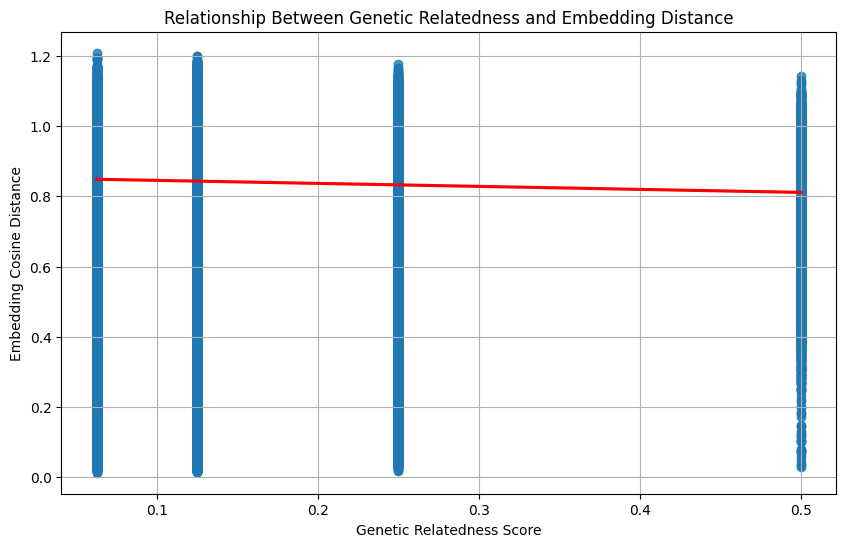

Pearson Correlation: -0.0398
P-value: 0.0000


In [20]:

# 3. Create a scatter plot to visualize the relationship
plt.figure(figsize=(10, 6))
sns.regplot(data=merged_df, x='relatedness', y='distance', line_kws={"color": "red"})
plt.title('Relationship Between Genetic Relatedness and Embedding Distance')
plt.xlabel('Genetic Relatedness Score')
plt.ylabel('Embedding Cosine Distance')
plt.grid(True)
plt.show()

# 4. Calculate the Pearson correlation
if not merged_df.empty:
    correlation, p_value = pearsonr(merged_df['relatedness'], merged_df['distance'])
    print(f"Pearson Correlation: {correlation:.4f}")
    print(f"P-value: {p_value:.4f}")
    # A negative correlation is expected: as relatedness increases, distance should decrease.
else:
    print("Could not merge any pairs to calculate correlation.")


In [ ]:
from scipy.stats import spearmanr


# Ensure there's data to analyze
if not merged_df.empty:
    # Calculate Spearman's rank correlation
    spearman_corr, spearman_p_value = spearmanr(merged_df['relatedness'], merged_df['distance'])

    print(f"Spearman's Rank Correlation: {spearman_corr:.4f}")
    print(f"P-value: {spearman_p_value:.5f}")
else:
    print("DataFrame is empty. Cannot calculate Spearman correlation.")

Spearman's Rank Correlation: -0.0143
P-value: 0.00000


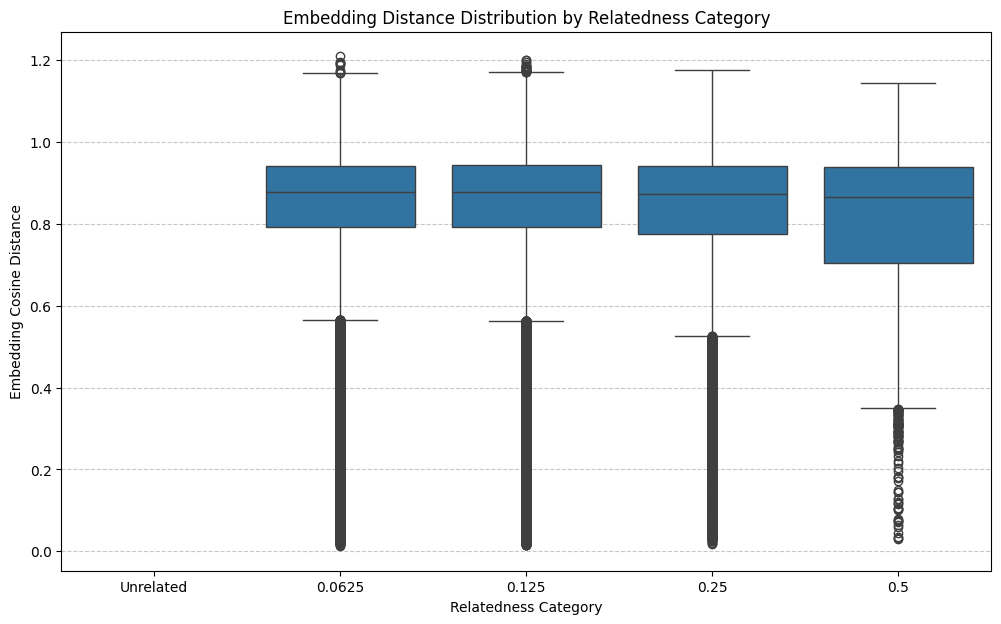

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

if not merged_df.empty:
    # 1. Create discrete bins for the 'relatedness' score.
    #    You can adjust the bins and labels based on your data's distribution.
    bins = [0, 0.05, 0.1, 0.2, 0.3, 0.6]  # Example bins for unrelated, half-siblings, full-siblings
    labels = ['Unrelated', '0.0625', '0.125', '0.25', '0.5']
    binned_df = merged_df.copy()
    binned_df['Relatedness Category'] = pd.cut(binned_df['relatedness'], bins=bins, labels=labels, right=False)

    # 2. Create the box plot
    plt.figure(figsize=(12, 7))
    sns.boxplot(data=binned_df, x='Relatedness Category', y='distance', order=labels)
    plt.title('Embedding Distance Distribution by Relatedness Category')
    plt.xlabel('Relatedness Category')
    plt.ylabel('Embedding Cosine Distance')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("DataFrame is empty. Cannot create box plot.")

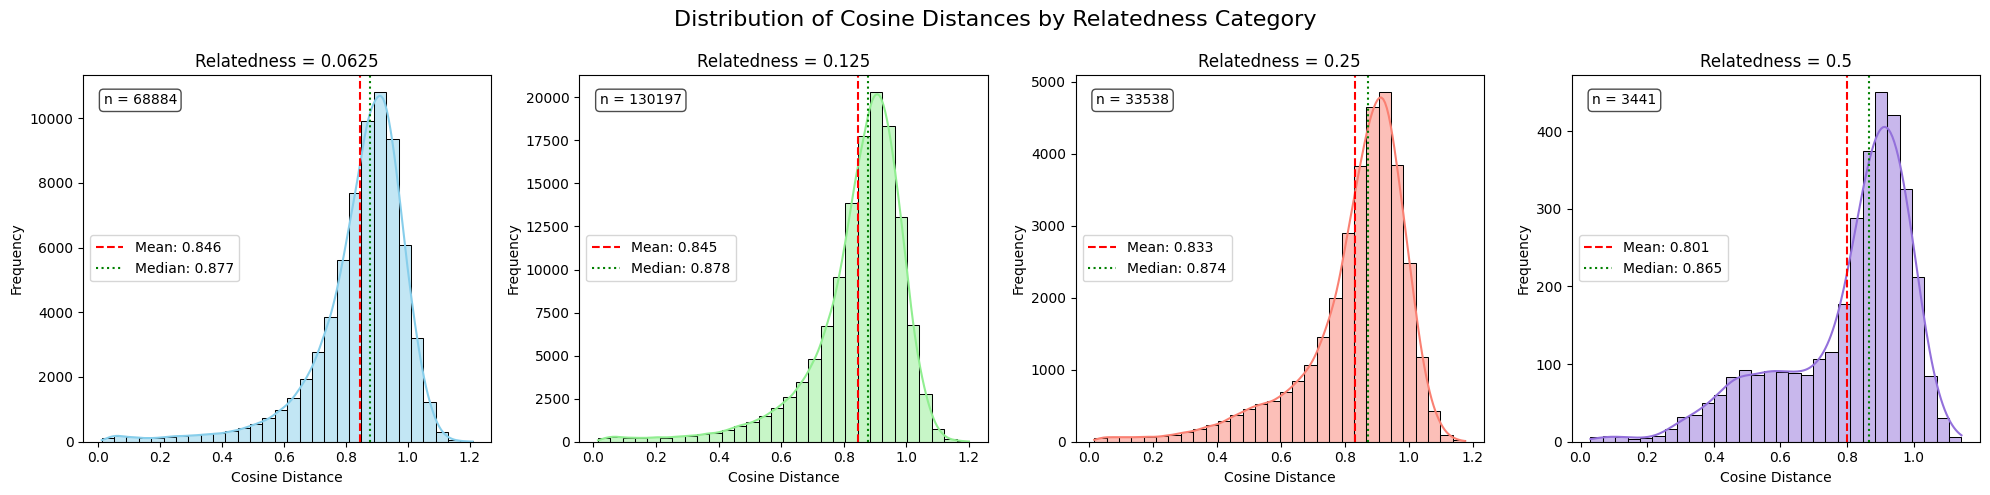

In [22]:
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

# Create subplots for each relatedness category
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle('Distribution of Cosine Distances by Relatedness Category', fontsize=16)

# Define the relatedness values to plot
relatedness_values = [0.0625, 0.125, 0.25, 0.5]

# Colors for the histograms
colors = ['skyblue', 'lightgreen', 'salmon', 'mediumpurple']

# Loop through each relatedness value and create a histogram
for i, rel_value in enumerate(relatedness_values):
    # Filter the data for this relatedness value
    rel_data = merged_df[merged_df['relatedness'] == rel_value]
    
    # Plot histogram
    sns.histplot(rel_data['distance'], bins=30, kde=True, ax=axes[i], color=colors[i])
    
    # Calculate mean and median
    mean_dist = rel_data['distance'].mean()
    median_dist = rel_data['distance'].median()
    
    # Add title and labels
    axes[i].set_title(f'Relatedness = {rel_value}')
    axes[i].set_xlabel('Cosine Distance')
    axes[i].set_ylabel('Frequency')
    
    # Add vertical lines for mean and median
    axes[i].axvline(mean_dist, color='red', linestyle='--', label=f'Mean: {mean_dist:.3f}')
    axes[i].axvline(median_dist, color='green', linestyle=':', label=f'Median: {median_dist:.3f}')
    
    # Add legend
    axes[i].legend()
    
    # Add text with number of samples
    axes[i].text(0.05, 0.95, f'n = {len(rel_data)}', 
             transform=axes[i].transAxes, 
             verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust to make room for the suptitle
plt.show()

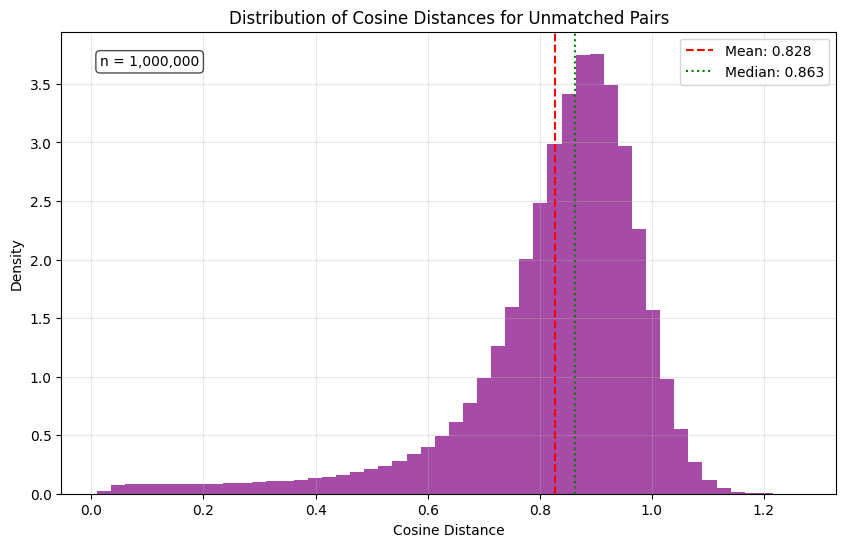

In [9]:
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
# Create a histogram to visualize distances in unmatched_df
plt.figure(figsize=(10, 6))

# Sample from unmatched_df if it's too large for efficient plotting
sample_size = min(1000000, len(unmatched_df))
sampled_unmatched = unmatched_df.sample(n=sample_size, random_state=42)

# Plot the histogram with a different color
plt.hist(sampled_unmatched['distance'], bins=50, alpha=0.7, color='purple', density=True)

# Add mean and median lines
mean_dist = sampled_unmatched['distance'].mean()
median_dist = sampled_unmatched['distance'].median()
plt.axvline(mean_dist, color='red', linestyle='--', label=f'Mean: {mean_dist:.3f}')
plt.axvline(median_dist, color='green', linestyle=':', label=f'Median: {median_dist:.3f}')

# Add labels and legend
plt.title('Distribution of Cosine Distances for Unmatched Pairs')
plt.xlabel('Cosine Distance')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.text(0.05, 0.95, f'n = {sample_size:,}', 
                 transform=plt.gca().transAxes, 
                 verticalalignment='top', 
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.show()

# Male female split

Spearman's Rank Correlation: -0.0143
P-value: 0.00000


/tmp/ipykernel_1618502/4035135114.py:18: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ids = pd.read_csv('/home/users/dash/guppies/pre_embeddings/merged_2m_id_split_4m.csv')


Total pairs: 236060
same_gender  gender_1  gender_2
True         female    female      75142
False        female    male        59236
             male      female      56623
True         male      male        45059
Name: count, dtype: int64


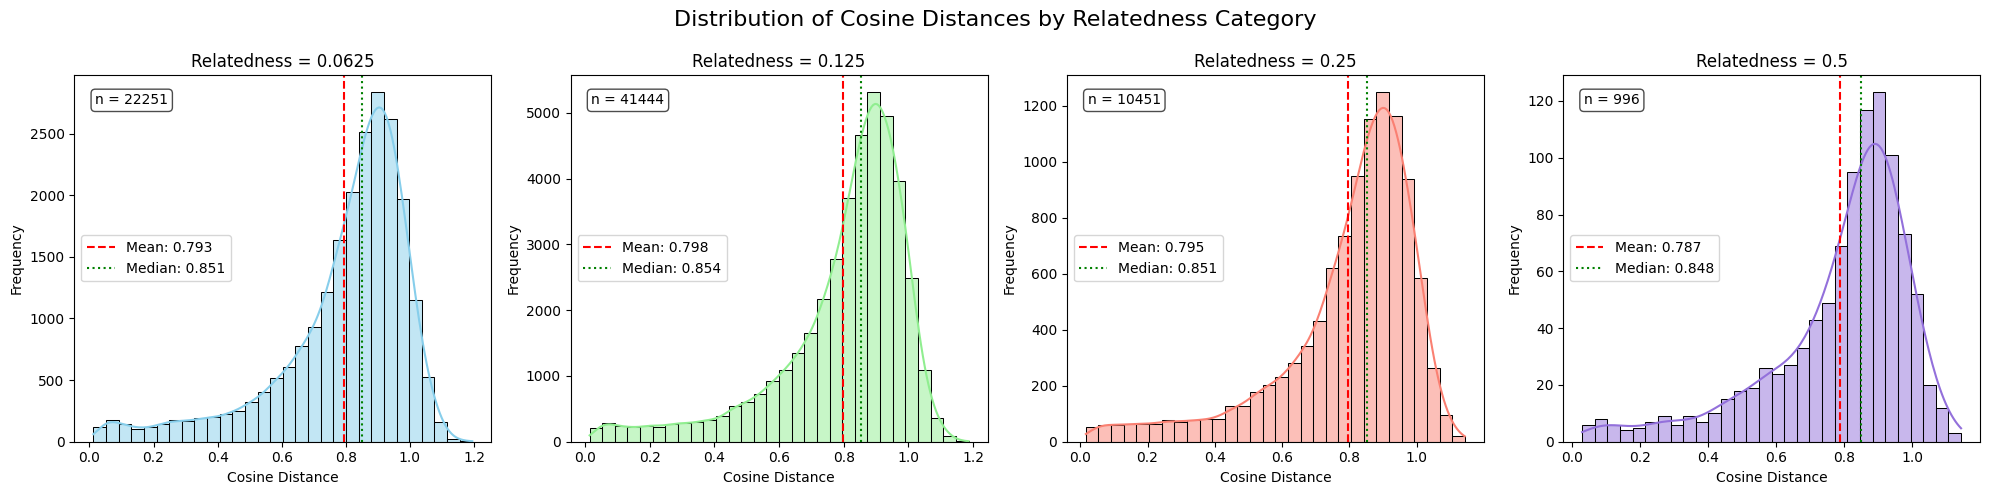


female-female pairs: 75142
Spearman correlation: 0.0024 (p=5.0741e-01)


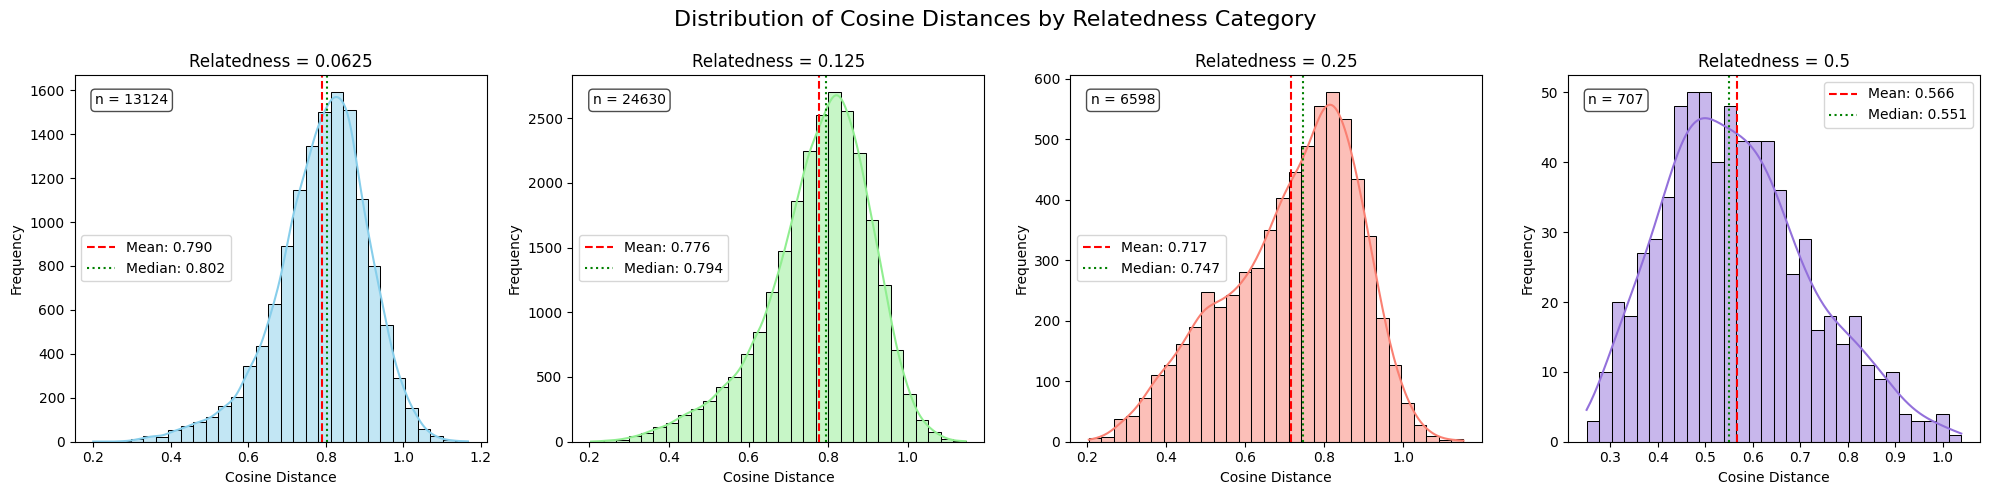


male-male pairs: 45059
Spearman correlation: -0.1475 (p=1.9269e-217)


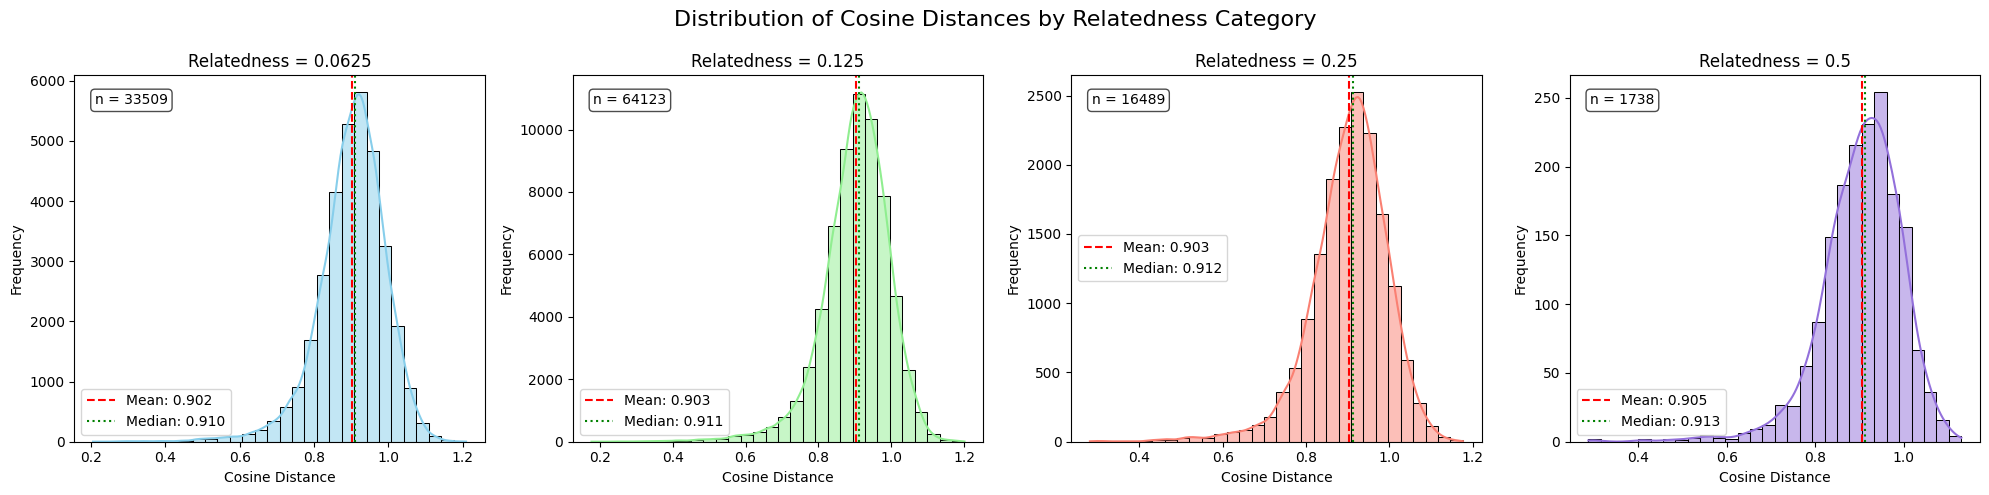


Cross-gender pairs: 115859
Spearman correlation: 0.0058 (p=4.9045e-02)


In [14]:
from scipy.stats import spearmanr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure there's data to analyze
if not merged_df.empty:
    # Calculate Spearman's rank correlation
    spearman_corr, spearman_p_value = spearmanr(merged_df['relatedness'], merged_df['distance'])

    print(f"Spearman's Rank Correlation: {spearman_corr:.4f}")
    print(f"P-value: {spearman_p_value:.5f}")
else:
    print("DataFrame is empty. Cannot calculate Spearman correlation.")
    
# split df_matched by gender and see if correlation improves!
# same with Knn matching, split by gender!
df_ids = pd.read_csv('/home/users/dash/guppies/pre_embeddings/merged_2m_id_split_4m.csv')
df_ids = df_ids[['FishID', 'individual_id']]
# Create gender columns based on first letter (F = female, M = male)
df_ids['gender'] = df_ids['FishID'].str[0].map({'F': 'female', 'M': 'male'})

# Create a dictionary to map individual_id to gender
id_to_gender = dict(zip(df_ids['individual_id'], df_ids['gender']))

# Add gender columns to merged_df 
merged_df['gender_1'] = merged_df['id_1'].map(id_to_gender)
merged_df['gender_2'] = merged_df['id_2'].map(id_to_gender)

# Create a column indicating if the pair is same gender
merged_df['same_gender'] = merged_df['gender_1'] == merged_df['gender_2']

# Print summary of gender matches
print(f"Total pairs: {len(merged_df)}")
print(merged_df[['same_gender', 'gender_1', 'gender_2']].value_counts())

# Calculate correlation for different gender subgroups
for gender in ['female', 'male']:
    # Same gender pairs
    same_gender_df = merged_df[(merged_df['gender_1'] == gender) & (merged_df['gender_2'] == gender)]
    if not same_gender_df.empty:
        plot_relatedness(same_gender_df)
        corr, p_val = spearmanr(same_gender_df['relatedness'], same_gender_df['distance'])
        print(f"\n{gender}-{gender} pairs: {len(same_gender_df)}")
        print(f"Spearman correlation: {corr:.4f} (p={p_val:.4e})")

# Cross-gender pairs
cross_gender_df = merged_df[merged_df['gender_1'] != merged_df['gender_2']]
if not cross_gender_df.empty:
    plot_relatedness(cross_gender_df)
    corr, p_val = spearmanr(cross_gender_df['relatedness'], cross_gender_df['distance'])
    print(f"\nCross-gender pairs: {len(cross_gender_df)}")
    print(f"Spearman correlation: {corr:.4f} (p={p_val:.4e})")


,id_1,id_2,relatedness,distance,gender_1,gender_2,same_gender
0,13591,16269,0.5000,0.925735,female,female,True
1,14934,20341,0.5000,0.195576,female,female,True
2,15648,20321,0.5000,0.931909,female,female,True
3,13591,21844,0.5000,0.875577,female,female,True
4,15808,22089,0.5000,0.893410,female,female,True
...,...,...,...,...,...,...,...
236055,50042,50141,0.0625,0.987591,male,female,False
236056,50111,50157,0.0625,0.553957,female,female,True
236057,50111,50162,0.0625,0.774293,female,female,True
236058,50072,50111,0.0625,0.834353,male,female,False


In [12]:
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
def plot_relatedness(merged_df):
    # Create subplots for each relatedness category
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
    fig.suptitle('Distribution of Cosine Distances by Relatedness Category', fontsize=16)

    # Define the relatedness values to plot
    relatedness_values = [0.0625, 0.125, 0.25, 0.5]

    # Colors for the histograms
    colors = ['skyblue', 'lightgreen', 'salmon', 'mediumpurple']

    # Loop through each relatedness value and create a histogram
    for i, rel_value in enumerate(relatedness_values):
        # Filter the data for this relatedness value
        rel_data = merged_df[merged_df['relatedness'] == rel_value]
        
        # Plot histogram
        sns.histplot(rel_data['distance'], bins=30, kde=True, ax=axes[i], color=colors[i])
        
        # Calculate mean and median
        mean_dist = rel_data['distance'].mean()
        median_dist = rel_data['distance'].median()
        
        # Add title and labels
        axes[i].set_title(f'Relatedness = {rel_value}')
        axes[i].set_xlabel('Cosine Distance')
        axes[i].set_ylabel('Frequency')
        
        # Add vertical lines for mean and median
        axes[i].axvline(mean_dist, color='red', linestyle='--', label=f'Mean: {mean_dist:.3f}')
        axes[i].axvline(median_dist, color='green', linestyle=':', label=f'Median: {median_dist:.3f}')
        
        # Add legend
        axes[i].legend()
        
        # Add text with number of samples
        axes[i].text(0.05, 0.95, f'n = {len(rel_data)}', 
                transform=axes[i].transAxes, 
                verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust to make room for the suptitle
    plt.show()
    return

# visualise embedding

In [15]:
from sklearn.manifold import TSNE

# Determine the number of samples
n_samples = embeddings.shape[0]

# Set perplexity to a value less than n_samples
perplexity_value = min(5, n_samples - 1)

# Initialize and fit t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
embeddings_2d = tsne.fit_transform(embeddings)


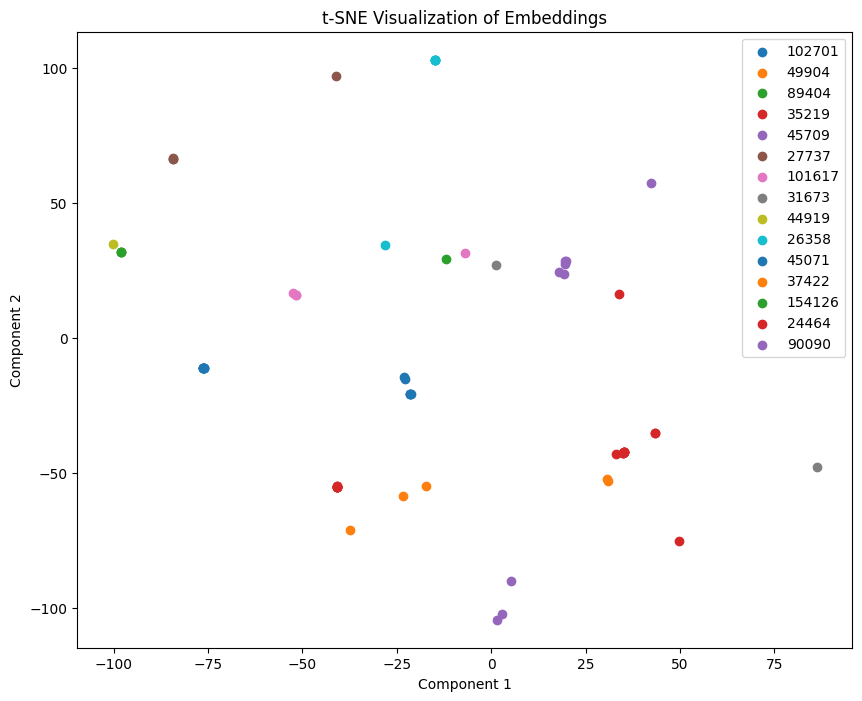

In [16]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(10, 8))
unique_labels = set(labels)

# for label in unique_labels:
#     indices = [i for i, l in enumerate(labels) if l == label]
#     plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=label)

random_labels = random.sample(list(unique_labels), 15)

for label in random_labels:
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=label)

plt.legend()
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


# accuracy 1-NN

In [24]:
from wildlife_tools.similarity import CosineSimilarity
from wildlife_tools.inference import KnnClassifier
import numpy as np



# Extract features
query_features = extractor(query_dataset)
database_features = features
# database_features = extractor(database_dataset)

# Compute cosine similarity
similarity_function = CosineSimilarity()
similarity = similarity_function(query_features, database_features)

# Perform 1-NN classification
classifier = KnnClassifier(k=1, database_labels=database_dataset.labels_string)
predictions = classifier(similarity)

# Evaluate accuracy
accuracy = np.mean(np.array(query_dataset.labels_string) == np.array(predictions))
print(f'1-NN Classification Accuracy: {accuracy:.2%}')


100%|█████████████████████████████████████████████████████████████| 260/260 [25:20<00:00,  5.85s/it]


1-NN Classification Accuracy: 37.31%


In [ ]:
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(embeddings)
# Initialize dictionaries to hold similarities
same_identity_sims = defaultdict(list)
different_identity_sims = defaultdict(list)

num_embeddings = len(embeddings)

for i in range(num_embeddings):
    for j in range(i + 1, num_embeddings):
        sim = similarity_matrix[i][j]
        if labels[i] == labels[j]:
            same_identity_sims[labels[i]].append(sim)
        else:
            key = f"{labels[i]} vs {labels[j]}"
            different_identity_sims[key].append(sim)

# Compute average similarities
avg_same_identity_sim = np.mean([np.mean(sims) for sims in same_identity_sims.values()])
avg_different_identity_sim = np.mean([np.mean(sims) for sims in different_identity_sims.values()])

print(f"Average similarity within the same identity: {avg_same_identity_sim:.4f}")
print(f"Average similarity between different identities: {avg_different_identity_sim:.4f}")

In [16]:
print(same_identity_sims.values())
print(different_identity_sims.values())

dict_values([[np.float32(0.6974768), np.float32(0.09702696), np.float32(0.87976694), np.float32(0.94433403), np.float32(0.13532045), np.float32(0.7862973), np.float32(0.9256374), np.float32(0.5699037), np.float32(0.6326706), np.float32(0.8611397), np.float32(0.88750315), np.float32(0.9132253), np.float32(0.9494519), np.float32(0.20080546), np.float32(0.7701068), np.float32(0.7697402), np.float32(0.8927848), np.float32(0.5951601), np.float32(0.7687601), np.float32(0.75620735), np.float32(0.7626793), np.float32(0.9081795), np.float32(0.8850136), np.float32(0.74874485), np.float32(0.87047017), np.float32(0.9114697), np.float32(0.6578307), np.float32(0.8842803), np.float32(0.9400009), np.float32(0.10583155), np.float32(0.82868147), np.float32(0.9161985), np.float32(0.6572112), np.float32(0.22914809), np.float32(0.7534605), np.float32(0.71426976), np.float32(0.19606319), np.float32(0.60475373), np.float32(0.70241904), np.float32(0.66581476), np.float32(0.6424886), np.float32(0.71664214), np

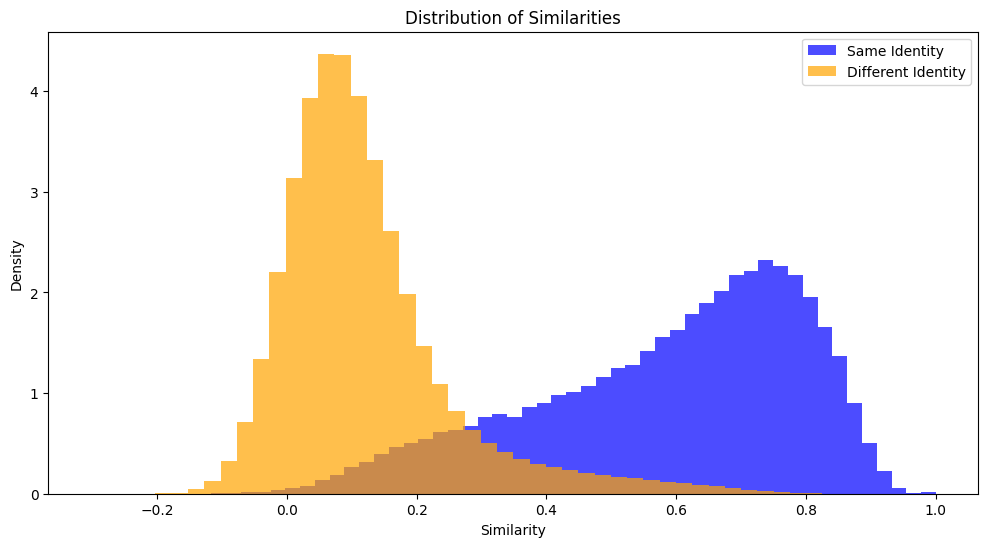

In [ ]:
plt.figure(figsize=(12, 6))

# Flatten the lists of similarities
same_identity_flat = [sim for sims in same_identity_sims.values() for sim in sims]
different_identity_flat = [sim for sims in different_identity_sims.values() for sim in sims]

# Plot histograms
plt.hist(same_identity_flat, bins=50, alpha=0.7, label='Same Identity', color='blue', density=True)
plt.hist(different_identity_flat, bins=50, alpha=0.7, label='Different Identity', color='orange', density=True)

# Add labels and legend
plt.title('Distribution of Similarities')
plt.xlabel('Similarity')
plt.ylabel('Density')
plt.legend()

plt.show()